### Mounting Google drive

In [ ]:
### Mouting Drive here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing Required Packages

In [ ]:
### Installing pacakages
!pip install git+https://github.com/davidbau/baukit

  Cloning https://github.com/davidbau/baukit to /tmp/pip-req-build-k13gg4ox
  Running command git clone --filter=blob:none --quiet https://github.com/davidbau/baukit /tmp/pip-req-build-k13gg4ox
  Resolved https://github.com/davidbau/baukit to commit 5e23007c02fd58f063200c5dc9033e90f092630d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for baukit: filename=baukit-0.0.1-py3-none-any.whl size=59669 sha256=79715852f463191efe09e193fe036858050c06d39bf9a559acff82c708cec879
  Stored in directory: /tmp/pip-ephem-wheel-cache-jw95xsc1/wheels/e2/7a/dc/eb53bf0e7f86297d7d9759d9eba117036e850e1bfc3bda0176
Successfully built baukit


In [ ]:
### Importing Required Libraries and Checking if GPU is present

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from baukit import Trace, TraceDict
from sklearn.model_selection import train_test_split

pathCorpus = "drive/MyDrive/TA/SEM1-NLP/HW3-NLP/TrainingCorpus"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Preparation
        a. Downloaded the snli package and uploaded to a folder in the drive
        b. From training set read 500 samples randomly
        c. Load the gpt2 model and tokenizer from hugginface transformers
        d. Using GPU instead of CPU

In [ ]:
### Loading dataset from drive
df = pd.read_csv(pathCorpus+"/snli_1.0/snli_1.0_train.txt", sep='\t')

### Getting 500 samples from training set
sampled_data = df.sample(500, random_state=42)[['gold_label', 'sentence1', 'sentence2']]

In [ ]:
sampled_data

,gold_label,sentence1,sentence2
451411,neutral,An older gentleman in an orange jumpsuit and g...,A man is cleaning up around his house.
70668,entailment,Boy and girl running along the beach.,Two people run on the beach.
208057,entailment,Four men do repair work on a roof.,Four men work with tools.
126424,contradiction,A long-haired young man skateboarding on the r...,A girl is riding a bike.
191670,neutral,A band performs on stage.,People are listening to a rock concert.
...,...,...,...
357247,neutral,A soccer player is on the field with his arms ...,The soccer player has no shirt on.
431949,entailment,"Little girls dressed in kimono's, wearing whit...",Girls are wearing costumes.
16764,contradiction,A man wearing white walks passed a shuttered b...,A man ran pass by a shuttered building that di...
5500,neutral,"a group of people, restrained by fencing, wait...",Some people are trying to get into a tent for ...


In [ ]:
### Loading gpt2 model and tokenizer
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

### Using gpu if available and moving model to GPU
model.to(device)

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## 2. Obtain Internal States
    a. Combine Sen1 and Sen2 with 'This has the same meaning'
    b. Obtain h.0.mlp hidden states
    c. Get sen 2 Hidden states only

In [ ]:
### combining sentences and adding them to sampled_data dict

sampled_data['combined_sentences'] = sampled_data.apply(lambda row: f"{row['sentence1']} This has the same meaning as: {row['sentence2']}", axis=1)
sentence_1_meaning = sampled_data.apply(lambda row: f"{row['sentence1']} This has the same meaning as:", axis=1)
print(sampled_data[['gold_label', 'combined_sentences']])

           gold_label                                 combined_sentences
451411        neutral  An older gentleman in an orange jumpsuit and g...
70668      entailment  Boy and girl running along the beach. This has...
208057     entailment  Four men do repair work on a roof. This has th...
126424  contradiction  A long-haired young man skateboarding on the r...
191670        neutral  A band performs on stage. This has the same me...
...               ...                                                ...
357247        neutral  A soccer player is on the field with his arms ...
431949     entailment  Little girls dressed in kimono's, wearing whit...
16764   contradiction  A man wearing white walks passed a shuttered b...
5500          neutral  a group of people, restrained by fencing, wait...
467454  contradiction  A person walks on a snowy sidewalk, lit by str...

[500 rows x 2 columns]


In [ ]:
### All the functions for Q2 are written here


## This function is to probe the layer and get hidden state
def getHiddenStatesCS(layerName, sampled_data):
  hidden_states_cs = []
  combined_sentences_list = sampled_data['combined_sentences'].tolist()
  for i in range(len(combined_sentences_list)):
    print("\r","Sentences processed ",i+1, end="")
    encoded_input = tokenizer(combined_sentences_list[i], return_tensors='pt')
    encoded_input.to(device)
    with Trace(model, layerName) as ret:
        _ = model(**encoded_input)
        representation = ret.output
        hidden_states_cs.append(representation)
  return hidden_states_cs

## This function is to probe multiple layers and get those hidden states
def getHiddenStatesCSMutipleLayers(layerNames, sampled_data):
  hidden_states_cs_dict = {}
  for x in layerNames:
          hidden_states_cs_dict[x] = []
  combined_sentences_list = sampled_data['combined_sentences'].tolist()
  for i in range(len(combined_sentences_list)):
    print("\r","Sentences processed ",i+1, end="")
    encoded_input = tokenizer(combined_sentences_list[i], return_tensors='pt')
    encoded_input.to(device)
    with TraceDict(model, layerNames) as ret:
        _ = model(**encoded_input)
        for x in layerNames:
          representation = ret[x].output
          hidden_states_cs_dict[x].append(representation)
  return hidden_states_cs_dict

## This function is to get only sen2 hidden states
def getHiddenStatesOfSen2(sentence_1_meaning, hidden_states_cs):
  sentence_1_meaning_list = sentence_1_meaning.tolist()
  hidden_states_sen2 = []
  for i in range(len(hidden_states_cs)):
    encoded_input = tokenizer(sentence_1_meaning_list[i], return_tensors='pt')
    hidden_states_sen2.append(hidden_states_cs[i][:, encoded_input['input_ids'].size()[1]: ,:])
  return hidden_states_sen2

## This function is to form final dataset
def getFinalSampledData(sampled_data, hidden_states_sen2):
  final_sampled_data = {}
  final_sampled_data['gold_label'] = sampled_data['gold_label']
  final_sampled_data['sentence1'] = sampled_data['sentence1']
  final_sampled_data['sentence2'] = sampled_data['sentence2']
  final_sampled_data['hidden_states'] = hidden_states_sen2
  return final_sampled_data

## This function is to save hidden states in pickle
def saveInPickle(hidden_states_sen2, final_sampled_data, layer_name):
  with open(pathCorpus+'/hidden_states_sen2'+layer_name+'.pkl', 'wb') as file:
      pickle.dump(hidden_states_sen2, file)

  with open(pathCorpus+'/final_sampled_data'+layer_name+'.pkl', 'wb') as file:
      pickle.dump(final_sampled_data, file)

  print("\n=======Saved Successfully======")

## This function is to get hidden states from pickle
def getFromPickle(layer_name):
  with open(pathCorpus+'/hidden_states_sen2'+layer_name+'.pkl', 'rb') as file:
    hidden_states_sen2 = pickle.load(file)

  with open(pathCorpus+'/final_sampled_data'+layer_name+'.pkl', 'rb') as file:
      final_sampled_data = pickle.load(file)

  print("\n=======Retrived Successfully======")
  return hidden_states_sen2, final_sampled_data

In [ ]:
### This cell is only for Q2
### Next cell covers Q2 and Q4 so prefer to run next cell

layer_name = 'transformer.h.0.mlp'
## first getting hidden state
hidden_states_cs = getHiddenStatesCS(layer_name, sampled_data)

## next getting hidden state of sen2
hidden_states_sen2 = getHiddenStatesOfSen2(sentence_1_meaning, hidden_states_cs)

## next getting final dataset
final_sampled_data = getFinalSampledData(sampled_data, hidden_states_sen2)

## next saving that into pickle
saveInPickle(hidden_states_sen2, final_sampled_data, 'h.0.mlp')

 Sentences processed  500
=======Saved Successfully======


In [ ]:
### This cell is for Q2 & Q4 and same as done for previous layer
### As probing the layers above 9 fails as unable to fit gpt2 in google colab
### so Probing till only 9th layer

## we are getting 4 layers hidden states at once
## h.0.mlp for Q2 and the rest h.3.mlp, h.9.mlp, h.9.attn for Q4
layerNames = ['transformer.h.0.mlp', 'transformer.h.3.mlp', 'transformer.h.9.attn', 'transformer.h.9.mlp']
hidden_states_cs_dict = getHiddenStatesCSMutipleLayers(layerNames, sampled_data) ## first getting hidden state
for x in layerNames:
  ## next getting hidden state of sen2
  if('attn' in x):
    ## As from attention layer we will get two Hidden states
    hs_x = []
    for hs in hidden_states_cs_dict[x]:
      hs_x.append(hs[0])
    hidden_states_sen2 = getHiddenStatesOfSen2(sentence_1_meaning, hs_x)
  else:
    hidden_states_sen2 = getHiddenStatesOfSen2(sentence_1_meaning, hidden_states_cs_dict[x])

  ## next getting final dataset
  final_sampled_data = getFinalSampledData(sampled_data, hidden_states_sen2)

  ## next saving them into pickle
  saveInPickle(hidden_states_sen2, final_sampled_data, x.replace("transformer.", ""))

 Sentences processed  500
=======Saved Successfully======

=======Saved Successfully======

=======Saved Successfully======

=======Saved Successfully======


## 3. Train a Classifier (25 points)
    a. Write Required Util functions for Padding, Encoding, Training and Testing
    b. Create different models and test on diff optimizers and Learning rates
    c. Run annd get best running model

In [ ]:
### These are functions for Q3

## Function to get maximum token size from all sample data
def getMaxTokens(hidden_states_sen2):
  max_size_sen2tokens = 0
  for x in hidden_states_sen2:
    max_size_sen2tokens = max(max_size_sen2tokens, x[0].size()[0])
  return max_size_sen2tokens

## Function to add padding to hidden states
def padHiddenStates(hidden_states_sen2, max_size_sen2tokens):
  hidden_states_sen2_pad = []
  hidden_states_sen2_pad_flatten = []
  for x in hidden_states_sen2:
    padded_hidden_states = torch.zeros(1, max_size_sen2tokens, 768)
    padded_hidden_states[:, :x.size(1), :] = x
    hidden_states_sen2_pad.append(padded_hidden_states)
    hidden_states_sen2_pad_flatten.append(torch.flatten(padded_hidden_states))
  return hidden_states_sen2_pad

## Function to process labels to convert to numeric
def convertLabelsIntoNumericLabels(final_sampled_data):
  ##convert labels to 0 1 and 2.. 0 for neutral 1 for...
  label_mapping = {'neutral': 0, 'entailment': 1, 'contradiction': 2}
  labels_numeric = torch.tensor([label_mapping[x] for x in final_sampled_data['gold_label']])
  return labels_numeric

## Util function to find diff no of labels count
def findLabelCount(labels_numeric):
  unique_values, counts = torch.unique(labels_numeric, return_counts=True)
  counts_dict = dict(zip(unique_values.tolist(), counts.tolist()))
  for label, count in counts_dict.items():
      print(f'Label {label}: Count {count}')

## Util function to get accuracy
def accuracyFun(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Util function to get accuracy by label
def accuracyFunByLabel(y_true, y_pred):
    ones = 0
    twos = 0
    zeros = 0
    for i in range(len(y_pred)):
      if(y_true[i]==0 and y_pred[i]==0):
        zeros += 1
      elif (y_true[i]==1 and y_pred[i]==1):
        ones += 1
      elif (y_true[i]==2 and y_pred[i]==2):
        twos += 1
    unique_values, counts = torch.unique(y_true, return_counts=True)
    count_act = {0:zeros, 1:ones, 2:twos}
    counts_dict = dict(zip(unique_values.tolist(), counts.tolist()))
    for label, count in counts_dict.items():
        print(f'Individual Label {label}: Count {count_act[label]}/{count}')

In [ ]:
### This contains function for loading the Model, train and testing

## Main function for loading model and using diff optimizers and learning rates
def runDifferentModels(modelName, X_train, Y_train, X_test, Y_test, X_val, Y_val, learning_rates, optimizers, num_epochs):
  for optimizer_type in optimizers:
      for learning_rate in learning_rates:
          print('\n==================================================================================')
          print(f'With Learning Rate ', learning_rate, ' and optimizer_type ', optimizer_type)
          print('-----------------------------------------------------------------------------------')
          model = getModel(modelName)
          if optimizer_type == 'Adam':
              optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
          elif optimizer_type == 'SGD':
              optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-3)
          model0 = trainAndTesting(model, optimizer, num_epochs, X_train, Y_train, X_test, Y_test, X_val, Y_val)
          # print('==================================================================================')


## Function for training and testing
def trainAndTesting(model, optimizer, num_epochs, X_train, Y_train, X_test, Y_test, X_val, Y_val):
  model.to(device)
  X_train, Y_train = X_train.to(device), Y_train.to(device)
  X_test, Y_test = X_test.to(device), Y_test.to(device)
  X_val, Y_val = X_val.to(device), Y_val.to(device)

  train_dataset = TensorDataset(X_train, Y_train)
  val_dataset = TensorDataset(X_val, Y_val)

  ## As our dataset size is small using batch size as dataset size
  batch_size = len(X_train)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  ## Training the model
  train_losses = []
  val_losses = []
  criterion = nn.CrossEntropyLoss() ## Using Cross entropy
  for epoch in range(num_epochs):
      model.train()
      epoch_train_losses = []
      for i, data in enumerate(train_loader,0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())

      average_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
      train_losses.append(average_train_loss)
      model.eval()
      with torch.no_grad():
          val_outputs = model(X_val)
          val_loss = criterion(val_outputs, Y_val)
          val_losses.append(val_loss.item())
          val_accuracy = (torch.argmax(val_outputs, dim=1) == Y_val).sum().item() / len(Y_val)

      if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_train_loss:.4f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')

  ## Testing the model
  model.eval()
  with torch.no_grad():
      test_outputs = model(X_test)
      test_loss = criterion(test_outputs, Y_test)
      test_accuracy = (torch.argmax(test_outputs, dim=1) == Y_test).sum().item() / len(Y_test)


  ## Displaying the metrics and plots
  print(f'\nTest Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}')
  accuracyFunByLabel(Y_test, torch.argmax(test_outputs, dim=1))

  plt.figure(figsize=(5, 3))
  plt.plot(train_losses, label='Train Loss', color='blue')
  plt.plot(val_losses, label='Validation Loss', color='orange')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Curves')
  plt.legend()
  plt.show()

  return model



In [ ]:
### A simple classifer

class SimpleClassifier8(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleClassifier8, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        x = nn.functional.adaptive_avg_pool1d(x, 1)
        x = x.squeeze()
        x = self.model(x)
        return x

In [ ]:
### This function is to get Models used for classication
### Created and Tested with 8 diff models with diff Optimizers
### and Learning rates out of which Two Models were picked for
### further testing => SimpleClassifer7 and SimpleClassifier8

def getModel(model):
  if(model=='SimpleClassifier'):
    input_size = 22 * 768
    hidden_size = 256
    output_size = 3
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
        )
  elif(model=='SimpleClassifier2'):
    input_size = max_size_sen2tokens * 768
    hidden_size1 = 512
    hidden_size2 = 256
    output_size = 3
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, hidden_size1),
        nn.ReLU(),
        nn.Linear(hidden_size1, hidden_size2),
        nn.ReLU(),
        nn.Linear(hidden_size2, output_size),
        nn.LogSoftmax(dim=1)
        )
  elif(model=='SimpleClassifier3'):
    input_size = max_size_sen2tokens * 768
    hidden_size1 = 512
    hidden_size2 = 256
    output_size = 3
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, hidden_size1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_size1, hidden_size2),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_size2, output_size),
        nn.LogSoftmax(dim=1)
        )
  elif(model=='SimpleClassifier4'):
    input_size = max_size_sen2tokens * 768
    hidden_size1 = 768
    hidden_size2 = 512
    hidden_size3 = 256
    output_size = 3
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, hidden_size1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_size1, hidden_size2),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_size2, hidden_size3),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_size3, output_size),
        nn.LogSoftmax(dim=1)
        )
  elif(model=='SimpleClassifier5'):
    input_size = max_size_sen2tokens * 768
    output_size = 3
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, output_size),
        nn.LogSoftmax(dim=1)
        )
  elif(model=='SimpleClassifier6'):
    input_size = max_size_sen2tokens * 768
    hidden_size = 22
    output_size = 3
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(hidden_size, output_size),
        nn.LogSoftmax(dim=1)
        )
  elif(model=='SimpleClassifier7'):
    input_size = max_size_sen2tokens * 768
    hidden_size = 768
    output_size = 3
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(hidden_size, output_size),
        nn.LogSoftmax(dim=1)
        )
  elif(model=='SimpleClassifier8'):
    input_size = 768
    output_size = 3
    return SimpleClassifier8(input_size, output_size)

In [ ]:
### Here we call every function we have created till now and create a flow

## Get the Hiddens states and sampled data from pickle
hidden_states_sen2, final_sampled_data = getFromPickle('h.0.mlp')

## We will get maximum size of token
max_size_sen2tokens = getMaxTokens(hidden_states_sen2)
print(max_size_sen2tokens)

## We will use that maximum size to add padding to others to make equal tensors
hidden_states_sen2_pad = padHiddenStates(hidden_states_sen2, max_size_sen2tokens)

## We will encode the labels
labels_numeric = convertLabelsIntoNumericLabels(final_sampled_data)

## Splitting Data into train/test/val train = 80%, test = 10%, Val = 10%
## X = hidden states, Y = labels
X_train = torch.tensor(np.array([t.detach().numpy() for t in hidden_states_sen2_pad])) #just converting list to tensors
X_train = X_train.squeeze()
Y_train = labels_numeric.clone().detach()
X_train, X_valt, Y_train, Y_valt = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_valt, Y_valt, test_size=0.5, random_state=42)

## Using util funcions to print the labels count
findLabelCount(labels_numeric)
findLabelCount(Y_train)
findLabelCount(Y_test)
findLabelCount(Y_val)

### learning rates optimizers and epochs we are using
### learning_rates = [0.0001, 0.001, 0.01, 0.1]
### optimizers = ['Adam', 'SGD']


## After Testing with Different Learning rates and Optimizers
## Came down to use Adam optimizer with
## 0.0001 learning rate => simpleClassifier7
## 0.1 learning rate => simpleClassifier8
## with Number of epochs as 30
## Out of which simpleClassifier8 worked well

optimizers = ['Adam']
learning_rates = [0.1]
num_epochs = 30
classifierName = 'SimpleClassifier8'


=======Retrived Successfully======
22
Label 0: Count 154
Label 1: Count 172
Label 2: Count 174
Label 0: Count 123
Label 1: Count 138
Label 2: Count 139
Label 0: Count 16
Label 1: Count 14
Label 2: Count 20
Label 0: Count 15
Label 1: Count 20
Label 2: Count 15



With Learning Rate  0.1  and optimizer_type  Adam
-----------------------------------------------------------------------------------
Epoch [1/30], Loss: 1.0937, Validation Loss: 1.3641, Validation Accuracy: 0.4800
Epoch [11/30], Loss: 0.5336, Validation Loss: 1.4195, Validation Accuracy: 0.5200
Epoch [21/30], Loss: 0.3459, Validation Loss: 1.2803, Validation Accuracy: 0.5000

Test Loss: 1.4707, Test Accuracy: 0.5600
Individual Label 0: Count 8/16
Individual Label 1: Count 10/14
Individual Label 2: Count 10/20


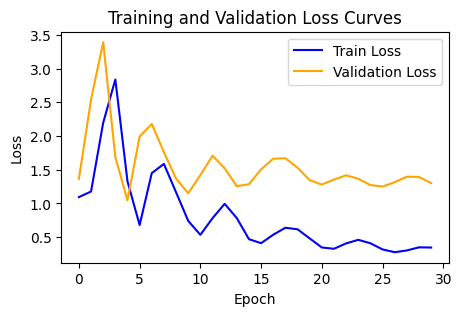

In [ ]:
### Here we run main function for h.0.mlp and We are using simpleClassifier8

runDifferentModels(classifierName, X_train, Y_train, X_test, Y_test, X_val, Y_val, learning_rates, optimizers, num_epochs)

## 4. Probe other layers
    a. Probing into h.3.mlp layer and run our classifier
    b. Probing into h.9.mlp layer and run our classifier
    b. Probing into h.9.attn layer and run our classifier


=======Retrived Successfully======

With Learning Rate  0.1  and optimizer_type  Adam
-----------------------------------------------------------------------------------
Epoch [1/30], Loss: 1.1006, Validation Loss: 1.1909, Validation Accuracy: 0.5000
Epoch [11/30], Loss: 0.3959, Validation Loss: 0.8868, Validation Accuracy: 0.6200
Epoch [21/30], Loss: 0.2699, Validation Loss: 0.9463, Validation Accuracy: 0.6600

Test Loss: 1.0234, Test Accuracy: 0.5800
Individual Label 0: Count 5/16
Individual Label 1: Count 9/14
Individual Label 2: Count 15/20


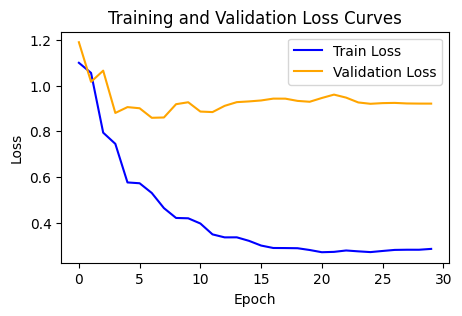

In [ ]:
### probing into other layers here we are using hidden states from h.3.mlp layer

hidden_states_sen2, final_sampled_data = getFromPickle('h.3.mlp')
max_size_sen2tokens = getMaxTokens(hidden_states_sen2)
hidden_states_sen2_pad = padHiddenStates(hidden_states_sen2, max_size_sen2tokens)
labels_numeric = convertLabelsIntoNumericLabels(final_sampled_data)
X_train = torch.tensor(np.array([t.detach().numpy() for t in hidden_states_sen2_pad]))
X_train = X_train.squeeze()
Y_train = labels_numeric.clone().detach()
X_train, X_valt, Y_train, Y_valt = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_valt, Y_valt, test_size=0.5, random_state=42)
runDifferentModels(classifierName, X_train, Y_train, X_test, Y_test, X_val, Y_val, learning_rates, optimizers, num_epochs)


=======Retrived Successfully======

With Learning Rate  0.1  and optimizer_type  Adam
-----------------------------------------------------------------------------------
Epoch [1/30], Loss: 1.1144, Validation Loss: 4.1248, Validation Accuracy: 0.3000
Epoch [11/30], Loss: 0.6282, Validation Loss: 1.6083, Validation Accuracy: 0.5200
Epoch [21/30], Loss: 0.3442, Validation Loss: 1.8501, Validation Accuracy: 0.4600

Test Loss: 1.7297, Test Accuracy: 0.6000
Individual Label 0: Count 11/16
Individual Label 1: Count 7/14
Individual Label 2: Count 12/20


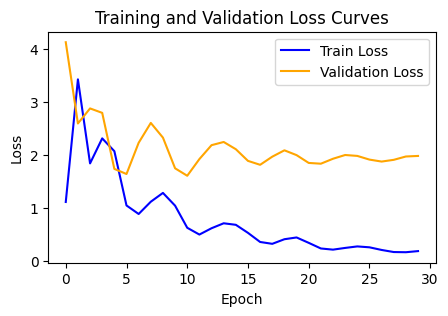

In [ ]:
### probing into other layers here we are using hidden states from h.9.mlp layer

hidden_states_sen2, final_sampled_data = getFromPickle('h.9.mlp')
max_size_sen2tokens = getMaxTokens(hidden_states_sen2)
hidden_states_sen2_pad = padHiddenStates(hidden_states_sen2, max_size_sen2tokens)
labels_numeric = convertLabelsIntoNumericLabels(final_sampled_data)
X_train = torch.tensor(np.array([t.detach().numpy() for t in hidden_states_sen2_pad]))
X_train = X_train.squeeze()
Y_train = labels_numeric.clone().detach()
X_train, X_valt, Y_train, Y_valt = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_valt, Y_valt, test_size=0.5, random_state=42)
runDifferentModels(classifierName, X_train, Y_train, X_test, Y_test, X_val, Y_val, learning_rates, optimizers, num_epochs)


=======Retrived Successfully======

With Learning Rate  0.1  and optimizer_type  Adam
-----------------------------------------------------------------------------------
Epoch [1/30], Loss: 1.1318, Validation Loss: 8.9128, Validation Accuracy: 0.3000
Epoch [11/30], Loss: 2.1342, Validation Loss: 2.3228, Validation Accuracy: 0.4000
Epoch [21/30], Loss: 0.8948, Validation Loss: 2.3774, Validation Accuracy: 0.4200

Test Loss: 2.4962, Test Accuracy: 0.4400
Individual Label 0: Count 11/16
Individual Label 1: Count 5/14
Individual Label 2: Count 6/20


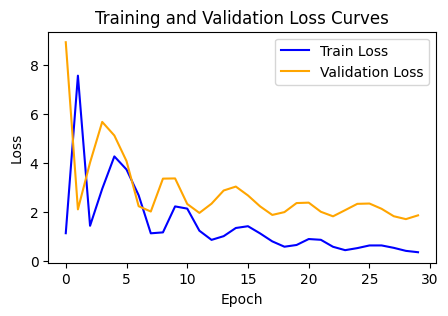

In [ ]:
### probing into other layers here we are using hidden states from h.9.attn layer

hidden_states_sen2, final_sampled_data = getFromPickle('h.9.attn')
max_size_sen2tokens = getMaxTokens(hidden_states_sen2)
hidden_states_sen2_pad = padHiddenStates(hidden_states_sen2, max_size_sen2tokens)
labels_numeric = convertLabelsIntoNumericLabels(final_sampled_data)
X_train = torch.tensor(np.array([t.detach().numpy() for t in hidden_states_sen2_pad]))
X_train = X_train.squeeze()
Y_train = labels_numeric.clone().detach()
X_train, X_valt, Y_train, Y_valt = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_valt, Y_valt, test_size=0.5, random_state=42)
runDifferentModels(classifierName, X_train, Y_train, X_test, Y_test, X_val, Y_val, learning_rates, optimizers, num_epochs)